In [64]:
import pandas as pd
import numpy as np
pd.set_option("max_rows", 100)

# 1.1 Парсинг данных https://github.com/owid/covid-19-data/tree/master/public/data
df = pd.read_csv("owid-covid-data.csv", sep = ',')
# обоснование добавления данных туризма - readme
df2 = pd.read_csv("tourists.csv", sep = ',')
df2.rename(columns = {'Country Code':'iso_code'}, inplace = True)
df2.drop(df2.columns.difference(['iso_code','2018']), 1, inplace=True)
#df['tests_units'] = df['tests_units'].fillna('no data')
df_count = np.max(df.count())
# добавить текстовое описание в файл readme.txt!
print ("{:<50} {:<10} {:<10}".format('feature',  '# of nan', '% of nan'))
for column in df.columns:
    print("{:<50} {:<10} {:<10}".format(column, 
                                        df[column].isnull().sum(),
                                        round(100 * df[column].isnull().sum() / df_count)))
print("Countries with no information about tourists: ",df2['2018'].isnull().sum(), " from ", np.max(df2.count()))

feature                                            # of nan   % of nan  
iso_code                                           0          0         
continent                                          11191      6         
location                                           0          0         
date                                               0          0         
total_cases                                        7565       4         
new_cases                                          7794       4         
new_cases_smoothed                                 8968       5         
total_deaths                                       26061      14        
new_deaths                                         26065      14        
new_deaths_smoothed                                27228      14        
total_cases_per_million                            8418       4         
new_cases_per_million                              8647       4         
new_cases_smoothed_per_million                     

In [65]:
#Оставить строчки с датами от 01 сентября 2021 и 200 дней после (~март-апрель 2022)
df['date']= ((pd.to_datetime(df['date']) - pd.to_datetime('2021-08-01')) / np.timedelta64(1, 'D')).astype(int)
df = df.drop(df[df['date'] < 0].index)
df = df.drop(df[df['date'] > 200].index)
# Удалить все агрегированные данные по континентам
df = df[df['continent'].notna()]
# Оставить только те атрибуты, для которых количество nan меньше 30%
df_count = np.max(df.count())
df = df.loc[:, df.isnull().sum(axis=0) < 0.3 * df_count]
print ("{:<50} {:<10} {:<10}".format('feature',  '# of nan', '% of nan'))
for column in df.columns:
    print("{:<50} {:<10} {:<10}".format(column, 
                                        df[column].isnull().sum(),
                                        round(100 * df[column].isnull().sum() / df_count)))

feature                                            # of nan   % of nan  
iso_code                                           0          0         
continent                                          0          0         
location                                           0          0         
date                                               0          0         
total_cases                                        2655       6         
new_cases                                          2686       6         
new_cases_smoothed                                 2702       6         
total_deaths                                       5361       12        
new_deaths                                         5400       12        
new_deaths_smoothed                                5454       12        
total_cases_per_million                            2655       6         
new_cases_per_million                              2686       6         
new_cases_smoothed_per_million                     

In [66]:
# 1.2 Предобработка данных и выделение значимых атрибутов
columns_to_delete = ['continent', 'location',
                 'total_cases', 'new_cases_per_million', 'new_cases_smoothed',
                 'total_deaths', 'new_deaths','new_deaths_smoothed', 'new_deaths_per_million',
                 'icu_patients', 'hosp_patients', 'weekly_icu_admissions',
                 'total_tests', 'new_tests', 'new_tests_per_thousand', 'new_tests_smoothed', 'positive_rate', 'tests_per_case', 'tests_units',
                 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
                 'new_vaccinations', 'new_vaccinations_smoothed',
                 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
                 'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred','new_people_vaccinated_smoothed',
                 'population_density', 'reproduction_rate',
                 'median_age', 'aged_65_older', 'aged_70_older',
                 'gdp_per_capita', 'extreme_poverty', 'hospital_beds_per_thousand',
                 'cardiovasc_death_rate', 'diabetes_prevalence',
                 'female_smokers', 'male_smokers',
                 'life_expectancy', 'human_development_index',
                 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative', 'excess_mortality']
df = df[df.columns.difference(columns_to_delete)]
df['immunity'] = (df['total_cases_per_million'] - df['total_deaths_per_million']) / 1000000 + 2 * df['new_people_vaccinated_smoothed_per_hundred']
df['month_cases_per_million'] = df['total_cases_per_million'] - np.roll(df['total_cases_per_million'], 30)
df['month_deaths_per_million'] = df['total_deaths_per_million'] - np.roll(df['total_deaths_per_million'], 30)
df.drop(columns=['total_cases_per_million', 'total_deaths_per_million'], inplace=True)
df.drop(columns=['new_cases', 'new_cases_smoothed_per_million','new_deaths_smoothed_per_million'], inplace=True)
df['Rt4'] = 0.0

df = df.sort_values(by=['iso_code', 'date'])
df = df.dropna()
data = df.to_numpy()
u, left_border = np.unique(data[:, df.columns.get_loc('iso_code')], return_index=True)
counties_number = u.size
right_border = np.roll(left_border, -1) 
right_border[-1] = data.shape[0]
for country in range(counties_number):
    for i in range(30):
        df.iloc[left_border[country] + i, df.columns.get_loc('month_cases_per_million')] = 0
        df.iloc[left_border[country] + i, df.columns.get_loc('month_deaths_per_million')] = 0
df.drop(columns=['population'], inplace = True)
data = df.to_numpy()
    
df_count = np.max(df.count())
print ("{:<50} {:<10} {:<10}".format('feature',  '# of nan', '% of nan'))
for column in df.columns:
    print("{:<50} {:<10} {:<10}".format(column, 
                                        df[column].isnull().sum(),
                                        round(100 * df[column].isnull().sum() / df_count)))

# Количество пустых данных в %
#print(100 - 100 * df.count() / data.shape[0])

feature                                            # of nan   % of nan  
date                                               0          0         
iso_code                                           0          0         
new_cases                                          0          0         
new_cases_smoothed_per_million                     0          0         
new_deaths_smoothed_per_million                    0          0         
new_people_vaccinated_smoothed_per_hundred         0          0         
new_vaccinations_smoothed_per_million              0          0         
stringency_index                                   0          0         
immunity                                           0          0         
month_cases_per_million                            0          0         
month_deaths_per_million                           0          0         
Rt4                                                0          0         


               date     new_cases  new_cases_smoothed_per_million  \
count  34365.000000  3.436500e+04                    34365.000000   
mean     101.738309  6.371057e+03                      342.696849   
std       57.337528  3.147757e+04                      862.728095   
min        0.000000  0.000000e+00                        0.000000   
25%       53.000000  1.700000e+01                        6.473000   
50%      102.000000  3.160000e+02                       58.748000   
75%      151.000000  2.266000e+03                      267.870000   
max      200.000000  1.383913e+06                    16052.608000   

       new_deaths_smoothed_per_million  \
count                     34365.000000   
mean                          1.816034   
std                           3.224904   
min                           0.000000   
25%                           0.057000   
50%                           0.479000   
75%                           2.089000   
max                          69.022000   


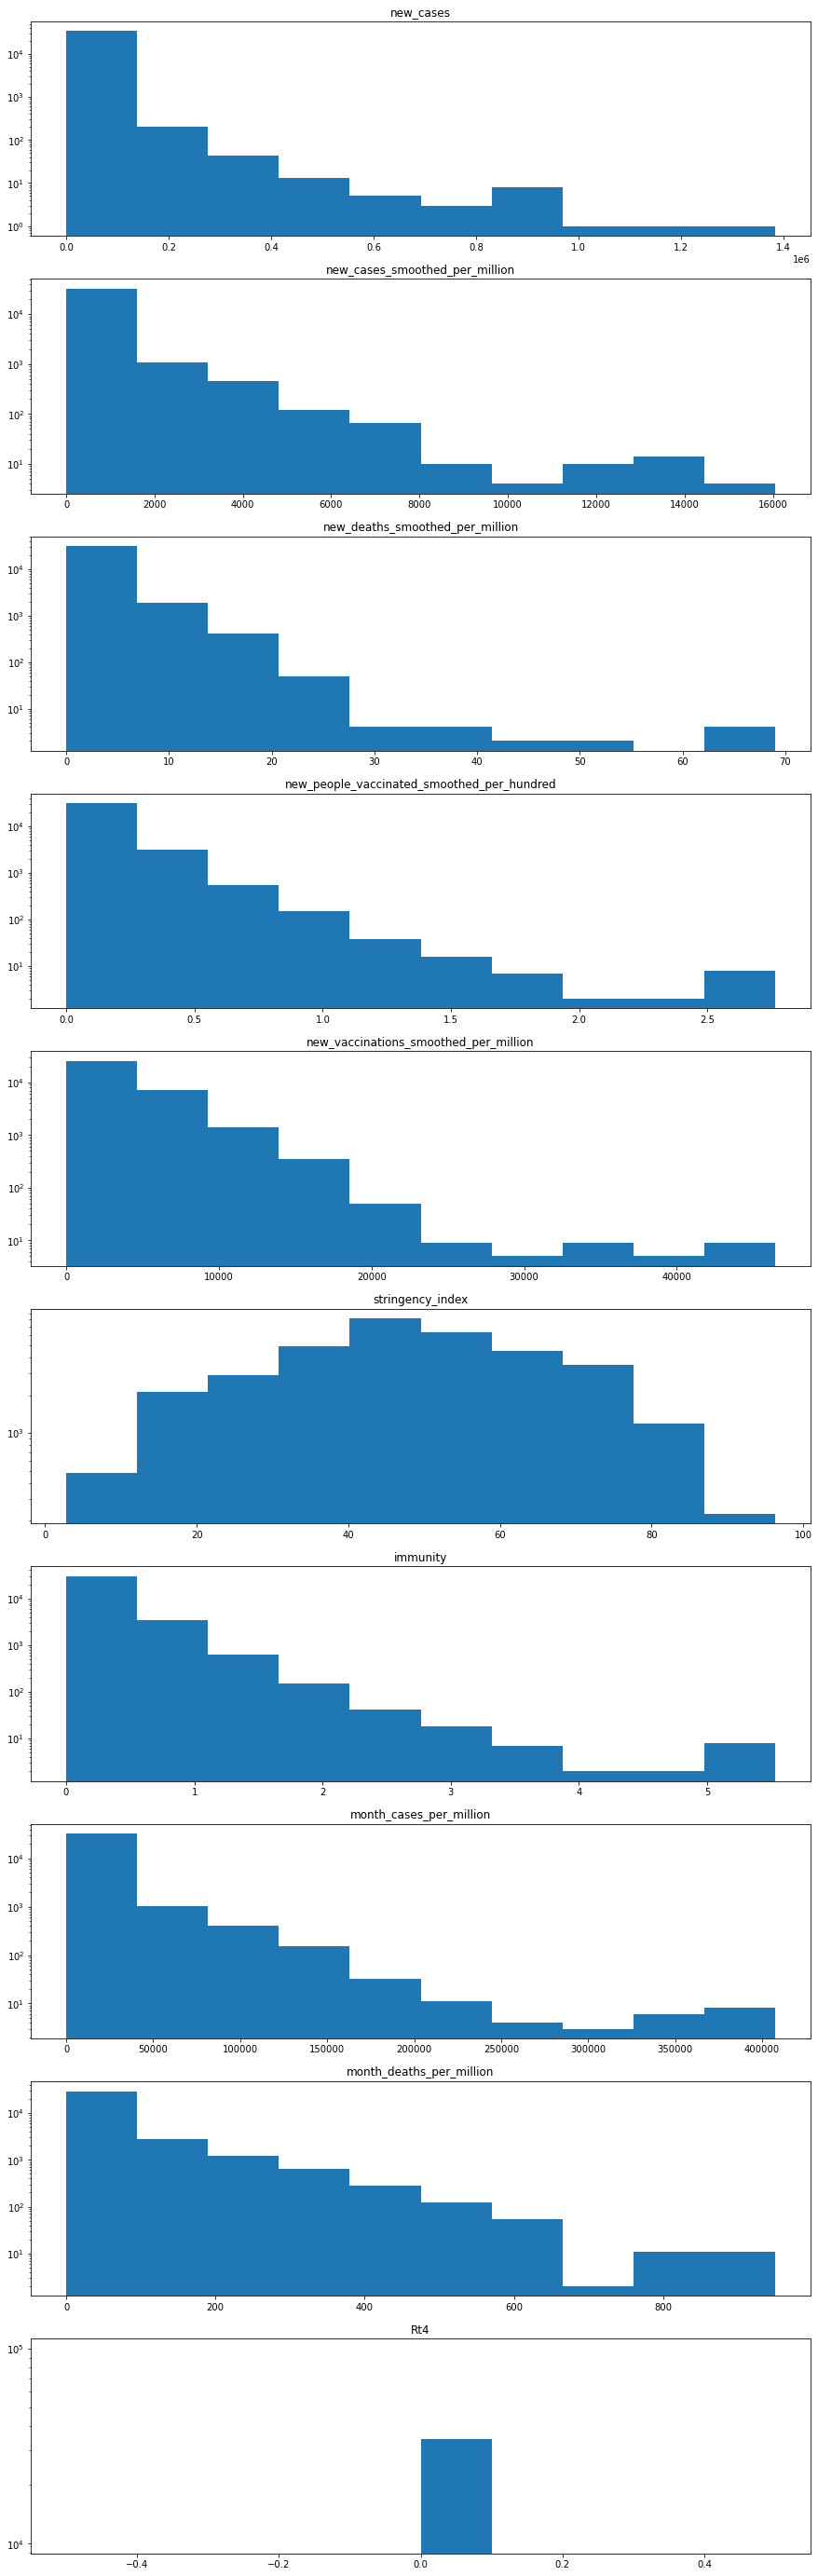

In [67]:
# 1.3 Описание структуры набора данных
# Информация об атрибутах находится на https://github.com/owid/covid-19-data/tree/master/public/data

import matplotlib.pyplot as plt

#fig, ax = plt.subplots()
#indices = list(range(left_border[2], right_border[2])) 
#line1 = ax.plot(data[indices, 0], data[indices, 2])
#line2 = ax.plot(data[indices, 0], data[indices, 3] * data[indices, df.columns.get_loc('population')] / 1000000)
#plt.show()

#fig, ax = plt.subplots()
#indices = list(range(left_border[2], right_border[2])) 
#line1 = ax.plot(data[indices, 0], data[indices, 5] * data[indices, df.columns.get_loc('population')] / 100)
#line2 = ax.plot(data[indices, 0], data[indices, 6] * data[indices, df.columns.get_loc('population')] / 1000000)
#plt.show()

print(df.describe())
figure, axis = plt.subplots((df.dtypes=='float64').sum(), 1)
figure.set_size_inches(15, 50)
i=0
for column in df.columns:
    if df.dtypes[column]=='float64':
        s=pd.Series(data[:, df.columns.get_loc(column)])
        axis[i].hist(s, bins=10, log=True)
        axis[i].set_title(column)
        i+=1
plt.show()

In [68]:
X = np.array(data[:, 2:])

print()

In [69]:
# 1.4 Формирование дополнительных атрибутов. Вычисление Rt по 4x4 дням согласно https://51.rospotrebnadzor.ru/content/809/51852/
from sklearn import decomposition

X = data[:, 2:]
X = X.astype(float)
pca = decomposition.PCA(n_components=2)
X_centered = (X - X.mean(axis=0)) / np.std(X, axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)
p=5
#plt.plot(X_pca[:,0], X_pca[:, 1], 'o')
plt.scatter(X_pca[:,0], X_pca[:, 1], s=10, c=(X[:,p] - np.min(X[:,p]))/(np.max(X[:,p]) - np.min(X[:,p])), cmap='jet')
#color = 1, 0, (X[:, 0] - np.min(X[:, 0])/(np.max(X[:, 0])-np.min(X[:, 0])))
#for i, component in enumerate(pca.components_):
  #  print("{} component: {}% of initial variance".format(i + 1,
 #           round(100*pca.explained_variance_ratio_[i], 2)))
 #   print(" + ".join("%.3f x %s" %(value, name)
  #                  for value, name in zip(component, 
  #                                        df.columns[2:])))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

ValueError: 'c' argument has 34365 elements, which is inconsistent with 'x' and 'y' with size 34368.

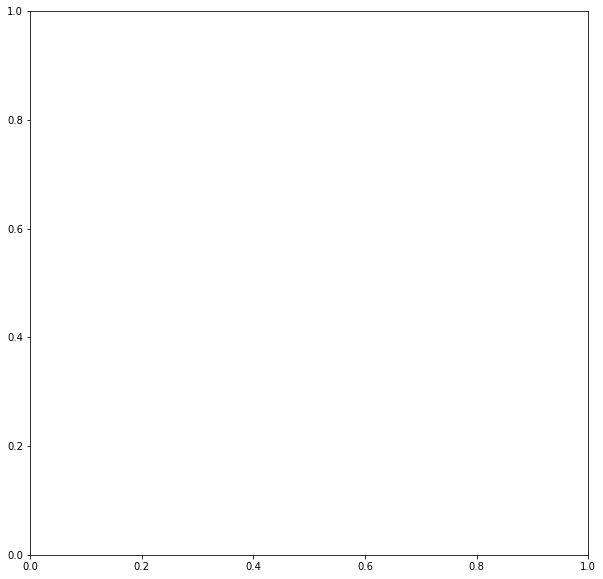

In [71]:
# 1.5 Кластеризация набора данных
# K-means       https://scikit-learn.org/stable/modules/clustering.html#k-means
# Mean shift    https://scikit-learn.org/stable/modules/clustering.html#mean-shift
# BIRCH         https://scikit-learn.org/stable/modules/clustering.html#birch
# Показатель оценки качества кластеризации: Компактность кластеров (Cluster Cohesion)

from sklearn.cluster import KMeans
X = data[:, 2:]
X = X.astype(float)


model = KMeans(n_clusters=3, random_state=0)
model.fit(X)
C = model.predict(X)
centroids = model.cluster_centers_


X_new = np.concatenate((X, centroids), axis = 0)
pca = decomposition.PCA(n_components=2)
X_centered = X_new
#(X_new - X_new.mean(axis=0)) / np.std(X_new, axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)
p=8
figure, axis = plt.subplots(1,1)
figure.set_size_inches(10, 10)
axis.scatter(X_pca[:,0], X_pca[:, 1], s=10, c=(X[:,p] - np.min(X[:,p]))/(np.max(X[:,p]) - np.min(X[:,p])), cmap='jet')
axis.scatter(X_pca[-2:,0], X_pca[-2:, 1], s=1000)

plt.show()

Automatically created module for IPython interactive environment


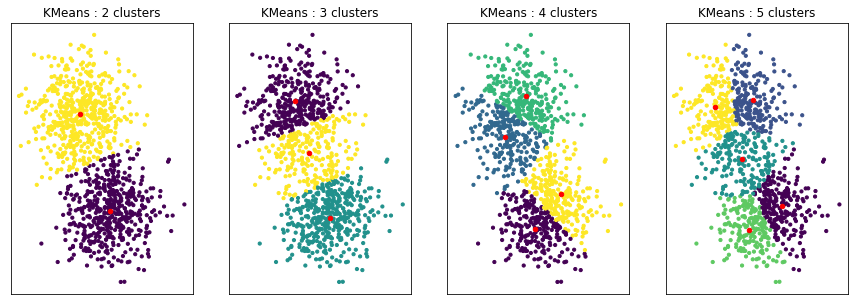

In [266]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans


print(__doc__)


# Generate sample data
n_samples = 1000
random_state = 0

X, _ = make_blobs(n_samples=n_samples, centers=2, random_state=random_state)

# Number of cluster centers for KMeans and BisectingKMeans
n_clusters_list = [2, 3, 4, 5]

# Algorithms to compare
clustering_algorithms = {
    "K-Means": KMeans,
}

# Make subplots for each variant
fig, axs = plt.subplots(
    len(clustering_algorithms), len(n_clusters_list), figsize=(15, 5)
)

axs = axs.T

for j, n_clusters in enumerate(n_clusters_list):
    algo = KMeans(n_clusters=n_clusters, random_state=random_state)
    algo.fit(X)
    centers = algo.cluster_centers_

    axs[j].scatter(X[:, 0], X[:, 1], s=10, c=algo.labels_)
    axs[j].scatter(centers[:, 0], centers[:, 1], c="r", s=20)

    axs[j].set_title(f"{'KMeans'} : {n_clusters} clusters")


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()